In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 100000)

In [2]:
nh = 128
refRatio = 2
finehalf = list(np.arange(int(nh / refRatio)))
omega = BT.Grid(nh)
omegaFine = omega
wavesFine = WT.MakeWaves(omega)
# omega.AddPatch(refRatio, finehalf)
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
wavesMod = waves @ nullspace
sigma = 0.1
mu = 0.5
c = 1.
nt = 160
CFL = 0.5

(11,)
(128, 128)
(128,)
(128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0. 

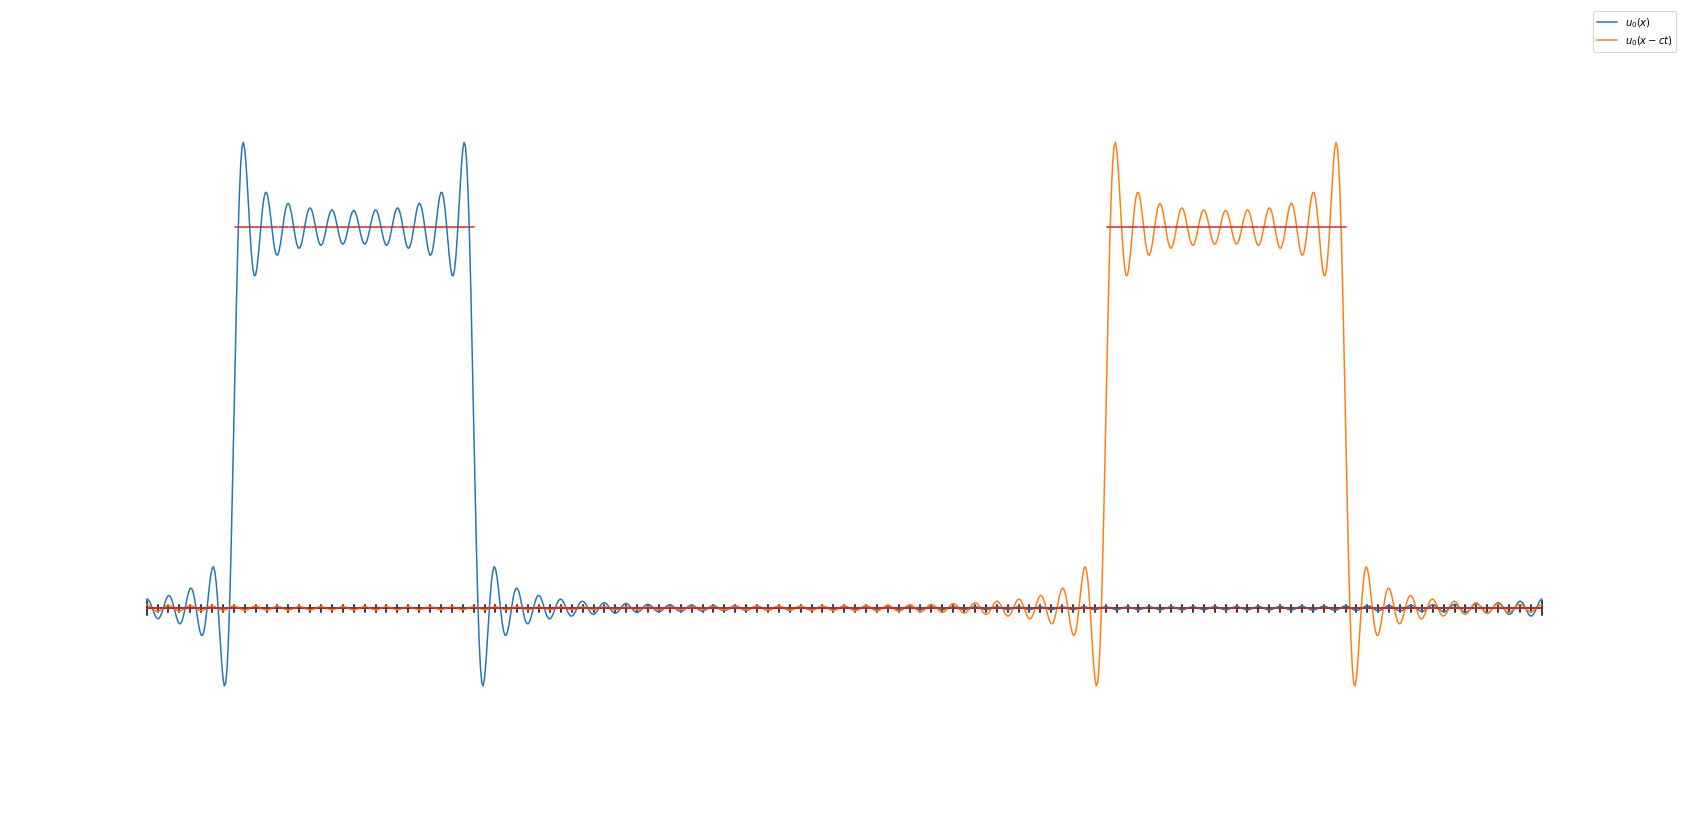

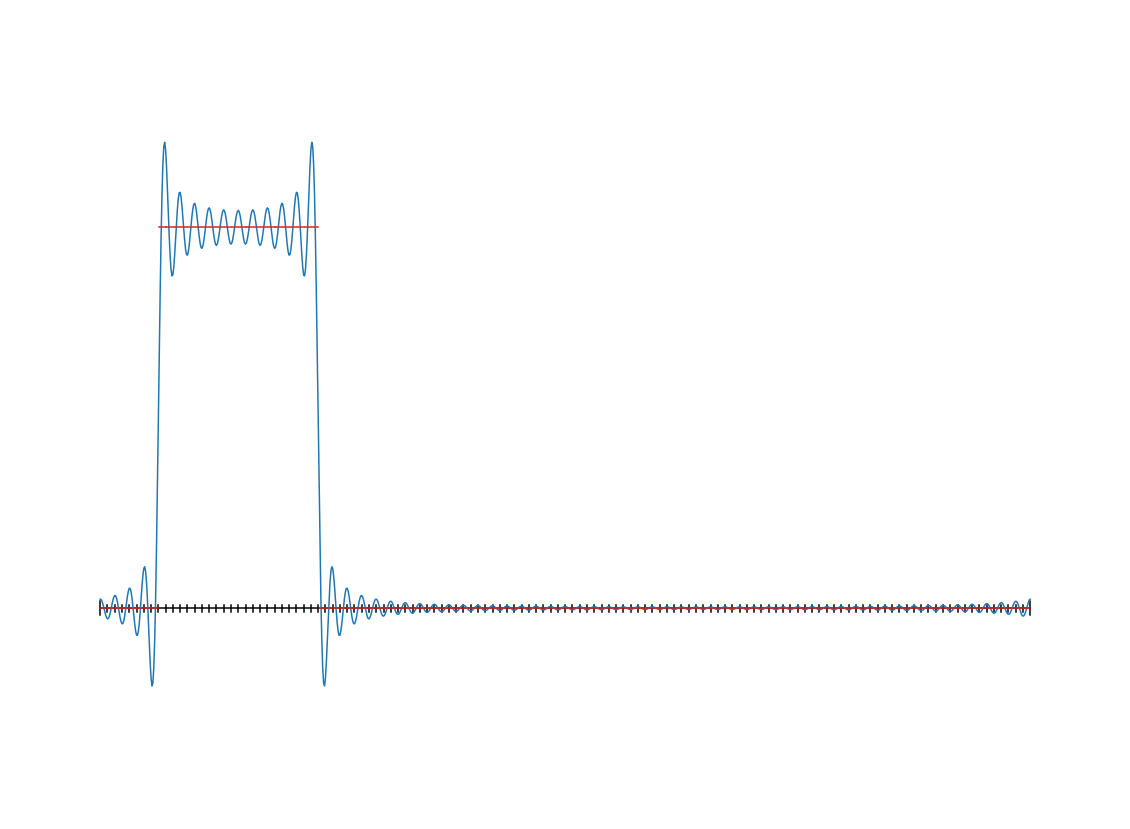

In [3]:
func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
func[8:30] = 1
print(np.shape(func[8:19]))
print(np.shape(wavesMod))
print(np.shape(func))
FCoefs = FFTT.FourierCoefs(omega, wavesMod, func)
# FCoefs[::2] = 0
gauss = wavesMod @ FCoefs
EulerCoefs, t = ST.ForwardEuler(omega, wavesMod, func, nt, c, CFL)
print(np.shape(EulerCoefs))
propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t, nullspace = nullspace)
print(np.shape(propFCoefs))
print(np.shape(FCoefs))
allCoefs = PT.Load(FCoefs, propFCoefs, EulerCoefs)
print('nullspace')
print(np.shape(allCoefs))
print('nullspace')
print(np.shape(nullspace @ allCoefs))
PT.PlotMixedWave(omega, waves, nullspace @ allCoefs, rescale = 6, labels = [r'$u_{0} (x)$', r'Reference $u_{0} (x - c t)$', r'Euler $u_{0} (x - c t)$'], dpi = 300)
PT.PlotMixedWave(omega, waves, nullspace @ FCoefs, rescale = [4,6])


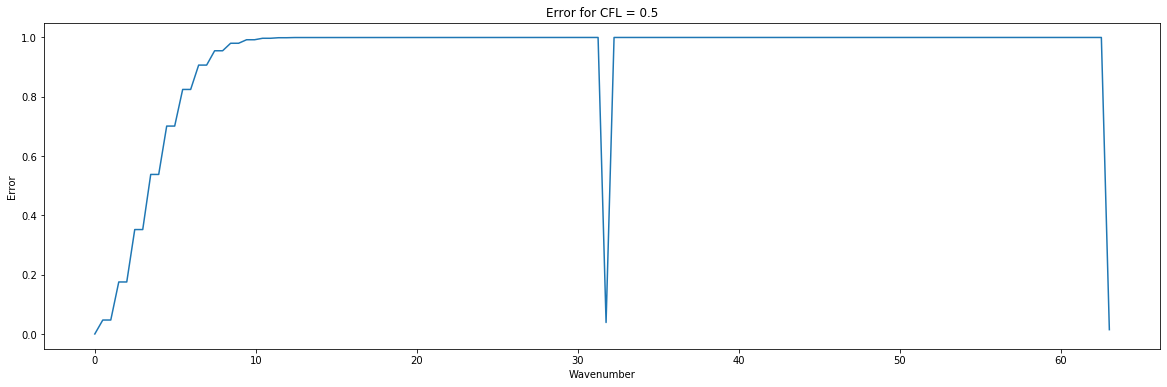

In [4]:
ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, error)
# plt.plot(ks, EulerCoefs)
# plt.plot(ks, propFCoefs)
plt.title('Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.show()

In [5]:
norms, CFLs = TT.NormVersusCFL(ST.ForwardEuler, omega, waves, gauss, c, CFL, nt, normType = 'L1', errorType = 'absolute')
plt.figure()
plt.plot(CFLs, norms)
plt.title('Error versus CFL Condition for Forward Euler')
plt.xlabel('CFL')
plt.ylabel('Error')
plt.show()


[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.         ...  0.          0.          1.        ]]
shape shift before: (128, 128)
shift coefs before: (128,)
shift coefs after: (128,)
[[ 1.          0.          0.         ...  0.          0.          0.        ]
 [ 0.         -0.70710678 -0.70710678 ...  0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.         ... -0.70710678 -0.70710678  0.        ]
 [ 0.          0.          0.       

SystemExit: ERROR:
TestTools:
NormVersusCFL:
t does not match t_0!
t_0 = 0.625
t = 0.6249999999999989

/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
A = np.arange(20)
B = A[::2][1:]
C = A[1::2][:-1]
print(A)
print(B)
print(C)
print(propFCoefs)

In [ ]:
ampKs, ampError = TT.AmpError(omega, EulerCoefs, propFCoefs)

In [ ]:
ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, ampError)
plt.title('Amplitude Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.show()

In [ ]:
deltaCoefs = np.ones(nh, float)
PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

In [ ]:
deltaCoefs[1::2] = 0
PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

In [ ]:
deltaCoefs = np.ones(nh, float)
deltaCoefs[::2] = 0
PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

In [ ]:
Cosine = lambda k: np.cos(2. * np.pi * k)
Sine = lambda k: np.sin(2. * np.pi * k)
RotMat = lambda k: np.asarray([Cosine(k), -Sine(k), Sine(k), Cosine(k)]).reshape(2, 2)
print(RotMat(0.125))

In [ ]:
def ExplicitMidpoint(omega, waves, u0, nt, const, CFL, periodic = True):
    degFreed = omega.degFreed
    x = omega.xCell
    dx = omega.dx
    dx_0 = 1 - x[::-1][0] + x[0]
    dt = CFL * dx / const
    dt_0 = CFL * dx_0 / const
    t = nt * dt[0]
    u = u0.copy()
    
    
#     for n in range(nt):
#         u_f = u[::-1][0]
#         u[1:] = u[1:] - (const * (dt / dx) * (u[1:] - u[:-1]))
#         if (periodic == True):
#             u[0] = u[0] - (const * (dt_0 / dx_0) * (u[0] - u_f))
    
    h = (b - a) / n;
halfh = h / 2;
y(1,:) = ya;
t(1) = a;
for i = 1 : n
    t(i+1) = t(i) + h;
    z = y(i,:) + halfh * f(t(i),y(i,:));
    y(i+1,:) = y(i,:) + h * f(t(i)+halfh,z);
    
    
    uCoefs = LA.inv(waves) @ u
    return uCoefs, t

In [ ]:
def MidpointMeth(omega, waves, u0, nt, const, CFL, periodic = True): # (def_fn, a, b, N, ya):
    degFreed = omega.degFreed
    x = omega.xCell
    dx = omega.dx
    dx_min = np.min(dx)
    dx_0 = 1 - x[::-1][0] + x[0]
    dt = CFL * dx_min / const
    dt_0 = CFL * dx_0 / const
    t = nt * dt
    u = u0.copy()
    u1 = u0.copy()
    for n in range(nt):
        u1, t = ST.ForwardEuler(omega, waves, u1, 1, const, CFL / 2, periodic = periodic)
        u2, t = ST.ForwardEuler(omega, waves, u + (dt * u1 / 2.), 1, const, CFL / 2, periodic = periodic)
        u = u + (dt * u2)
    uCoefs = LA.inv(waves) @ u

    return uCoefs, t

In [ ]:
nh = 64
refRatio = 2
omega = BT.Grid(nh)
waves = WT.MakeWaves(omega)
nt = 20

In [ ]:
func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
func[8:30] = 1
print(np.shape(wavesMod))
print(np.shape(func))
FCoefs = FFTT.FourierCoefs(omega, waves, func)
# FCoefs[::2] = 0
EulerCoefs, t = MidpointMeth(omega, waves, func, nt, c, CFL)
print(np.shape(EulerCoefs))
# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
allCoefs = PT.Load(FCoefs, EulerCoefs)
PT.PlotMixedWave(omega, waves, allCoefs, rescale = [4, 6], labels = [r'$u_{0} (x)$', r'Midpoint Method $u_{0} (x - c t)$'], save = True)

